# Data Exploration

## Set up

In [2]:
# common imports
import os
import csv
import pandas as pd
import numpy as np
import sys

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

sys.path.insert(0, '/Users/israfelsalazar/Documents/mva/ALTEGRAD/graph-challenge')

%load_ext autoreload
%autoreload 2

from graph_challenge.dataset.utils import *

In [3]:
root = "../data.nosync/"
sequence_path = os.path.join(root, "sequences.txt")
labels_path = os.path.join(root, "graph_labels.txt")

In [59]:
# read sequences
sequences = list()
with open(sequence_path, 'r') as f:
    for line in f:
        sequences.append(line[:-1])

# read lables and split
sequences_train = list()
sequences_test = list()
proteins_test = list()
y_train = list()
with open(labels_path, 'r') as f:
    for i,line in enumerate(f):
        t = line.split(',')
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            y_train.append(int(t[1][:-1]))


N Proteines: 6111
Max Lenght: 989
Min Lenght: 9
----------
TRAIN
N Proteines: 4888
Max Lenght: 989
Min Lenght: 9
----------
Test
N Proteines: 1223
Max Lenght: 910
Min Lenght: 18


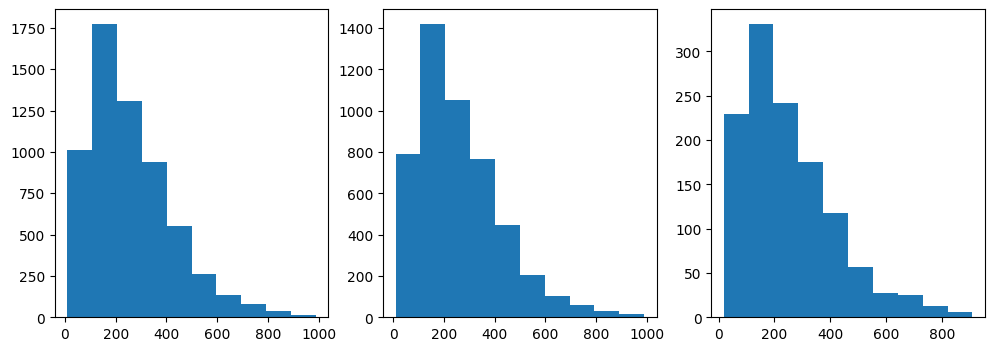

In [60]:
sequences_lenght = [len(word) for word in sequences]
train_lengths = [len(word) for word in sequences_train]
test_lengths = [len(word) for word in sequences_test]


print(f"N Proteines: {len(sequences)}")
print(f"Max Lenght: {np.max(sequences_lenght)}")
print(f"Min Lenght: {np.min(sequences_lenght)}")
print("-"*10)
print("TRAIN")
print(f"N Proteines: {len(sequences_train)}")
print(f"Max Lenght: {np.max(train_lengths)}")
print(f"Min Lenght: {np.min(train_lengths)}")
print("-"*10)
print("Test")
print(f"N Proteines: {len(sequences_test)}")
print(f"Max Lenght: {np.max(test_lengths)}")
print(f"Min Lenght: {np.min(test_lengths)}")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(sequences_lenght)
plt.subplot(1,3,2)
plt.hist(train_lengths)
plt.subplot(1,3,3)
plt.hist(test_lengths)
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


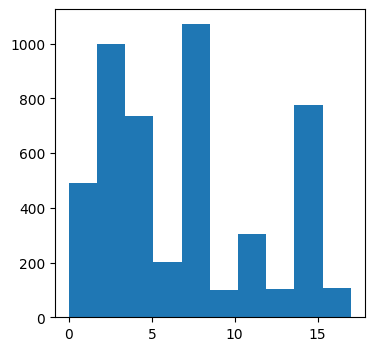

In [61]:
print(np.unique(y_train))
      
plt.figure(figsize=(4,4))
plt.hist(y_train)
plt.show()

In [65]:
y_train = np.asarray(y_train)
sequences_train = np.asarray(sequences_train)

In [75]:
label0 = [len(word) for word in sequences_train[y_train == 4]]

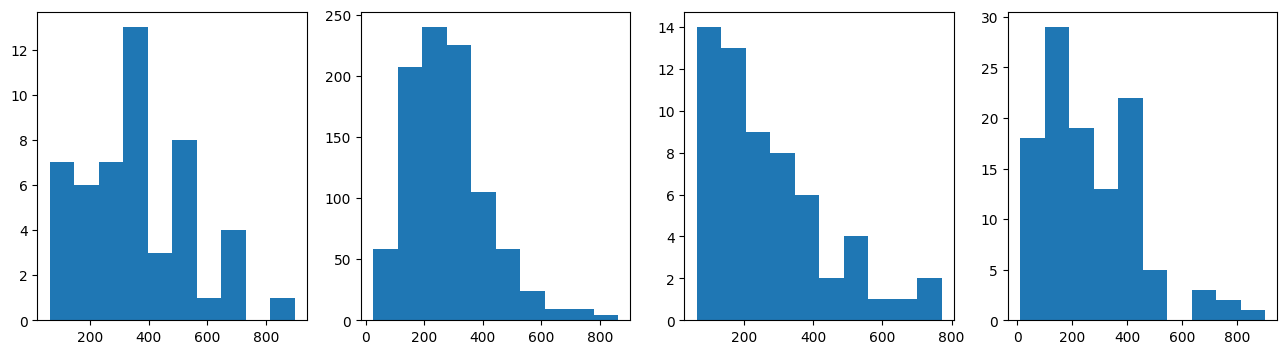

In [82]:
plt.figure(figsize=(16,4))
for i in range(1,5):
    aux_list = [len(word) for word in sequences_train[y_train == i]]
    plt.subplot(1,4,i)
    plt.hist(aux_list)
plt.show()

In [89]:
graph_indicator = np.loadtxt(os.path.join(root, "graph_indicator.txt"), dtype=np.int64)
_, graph_size = np.unique(graph_indicator, return_counts=True)

In [93]:
edges = np.loadtxt(os.path.join(root, "edgelist.txt"), dtype=np.int64, delimiter=",")
edges_inv = np.vstack((edges[:, 1], edges[:, 0]))

In [96]:
s = edges[:, 0] * graph_indicator.size + edges[:, 1]

In [135]:
adj, features, edge_features = load_graph_data(root)

In [138]:
adj, features, edge = load_graph_data(root)
normalized_adj = [normalize_adjacency(A) for A in adj]
(adj_train, features_train, y_train, adj_test,
 features_test) = split_dataset(root, normalized_adj, features)

# Create Datamodules
#train_gen = GraphProteinDataset(adj_train, features_train, y_train)
#val_gen = GraphProteinDataset(adj_test, features_test)

In [140]:
len(y_train)

4888

In [147]:
a = [[0,0,0,0], [1,1,1,1,1,1], [2,2,2,2,2,2,2,2]]
assert len(adj) == len(features) == 6111

In [146]:
len(adj)

6111

In [155]:
import csv

from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.loggers import WandbLogger

from graph_challenge.model import GraphNeuralNetwork
from graph_challenge.dataset.utils import load_data, split_dataset
from graph_challenge.dataset.datasets import (GraphProteinDataset,
                                              collate_graph_batch)


def collatebatch(batch):
    adj_batch = list()
    features_batch = list()
    idx_batch = list()
    for t, (adj, features) in enumerate(batch):
        n = adj.shape[0]
        adj_batch.append(adj + sp.identity(n))
        features_batch.append(features)
        idx_batch.extend([t] * n)
    adj_batch = sp.block_diag(adj_batch)
    features_batch = np.vstack(features_batch)
    return {
        'x': torch.FloatTensor(features_batch),
        'adj': sparse_mx_to_torch_sparse_tensor(adj_batch),
        'index': torch.LongTensor(idx_batch),
    }


batch_size = 64
n_hidden = 64
n_input = 86
dropout = 0.2
learning_rate = 0.001
n_class = 18
root = "/Users/israfelsalazar/Documents/mva/ALTEGRAD/graph-challenge/data.nosync"
model = GraphNeuralNetwork.load_from_checkpoint("/Users/israfelsalazar/Documents/mva/ALTEGRAD/graph-challenge/lightning_logs/xei4fbd8/checkpoints/epoch=59-step=3720.ckpt", 
                                                input_dim=n_input,
                                                output_dim=n_class,
                                                dropout=dropout)
# disable randomness, dropout, etc...
model.eval()
y_pred_proba = list()
train_set, test_set, _ = load_data(root)
adj, features, _, _, proteins_test = test_set
test_gen = GraphProteinDataset(adj, features)
test_loader = DataLoader(test_gen,
                            collate_fn=collatebatch,
                            batch_size=64)

for batch in test_loader:
    output = model(batch["x"], batch["adj"], batch["index"])
    y_pred_proba.append(output)

y_pred_proba = torch.cat(y_pred_proba, dim=0)
y_pred_proba = torch.exp(y_pred_proba)
y_pred_proba = y_pred_proba.detach().cpu().numpy()

# Write predictions to a file
with open('submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class' + str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba[i, :].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)

In [60]:
def load_data(data_dir, max_length=None):
    graph_indicator = np.loadtxt(os.path.join(data_dir, "graph_indicator.txt"),
                                 dtype=np.int64)
    _, graph_size = np.unique(graph_indicator, return_counts=True)

    edges = np.loadtxt(os.path.join(data_dir, "edgelist.txt"),
                       dtype=np.int64,
                       delimiter=",")
    edges_inv = np.vstack((edges[:, 1], edges[:, 0]))
    print(edges_inv.shape)
    s = edges[:, 0] * graph_indicator.size + edges[:, 1]
    idx_sort = np.argsort(s)
    edges = edges[idx_sort, :]
    edges, idx_unique = np.unique(edges, axis=0, return_index=True)
    A = sp.csr_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                      shape=(graph_indicator.size, graph_indicator.size))

    x = np.loadtxt(os.path.join(data_dir, "node_attributes.txt"),
                   delimiter=",")
    edge_attr = np.loadtxt(os.path.join(data_dir, "edge_attributes.txt"),
                           delimiter=",")
    
    A_dist = sp.csr_matrix((edge_attr[:,0], (edges[:, 0], edges[:, 1])),
                      shape=(graph_indicator.size, graph_indicator.size))
    
    #edge_attr = np.vstack((edge_attr, edge_attr))
    #edge_attr = edge_attr[idx_sort, :]
    #edge_attr = edge_attr[idx_unique, :]
    

    adj = []
    features = []
    #edge_features = []
    adj_dist = []
    idx_n = 0
    idx_m = 0
    for i in range(graph_size.size):
        adj.append(A[idx_n:idx_n + graph_size[i], idx_n:idx_n + graph_size[i]])
        adj_dist.append(A_dist[idx_n:idx_n + graph_size[i], idx_n:idx_n + graph_size[i]])
        #edge_features.append(edge_attr[idx_m:idx_m + adj[i].nnz, :])
        features.append(x[idx_n:idx_n + graph_size[i], :])
        idx_n += graph_size[i]
        idx_m += adj[i].nnz

    sequences = list()
    with open(os.path.join(data_dir, "sequences.txt"), 'r') as f:
        for line in f:
            sequences.append(line[:-1])
    sequences = [[*seq] for seq in sequences]
    if max_length is not None:
        sequences = [list(seq)[:max_length - 2] for seq in sequences]

    adj = [normalize_adjacency(A) for A in adj]
    adj_dist = [normalize_adjacency(A) for A in adj_dist]

    train_set, test_set, protein_test = split_testset(
        data_dir, (adj, features, adj_dist, sequences))
    return train_set, test_set, protein_test

In [61]:
train, test, p = load_data(root, 1024)

(2, 15213222)
(1572264, 1572264)
(1572264, 1572264)


TypeError: cannot unpack non-iterable NoneType object